## ASFS Slowsled (1-min) avergae preliminary look at fluxes
Goals
- need to calculate perturbation around mean, can use metpy functions for this but may want to do this myself.
    - maybe check out how they are doing that and ask Jessica what the best way is. 
- look at w'T', w'q', w'v', w'u'
- see how they correlate with one another
- see estimate for diurnal cycle
- use 10 minute averaging time for computation of turbulence? Or 1-hour?

In [ ]:
import os
import ftplib
from contextlib import closing
import urllib.request
import io

import matplotlib.pyplot as plt
import hvplot.xarray
import pandas as pd
import numpy as np
import xarray as xr

# from metpy import calc, units
# import metpy.xarray as mxarray
# import metpy.plots as metplots


: 

In [2]:
ftp = ftplib.FTP('ftp1.esrl.noaa.gov') # Connect to NOAA's FTP
ftp.login() # Anonymous login
ftp.cwd('./Observations/Campaigns/SPLASH/asfs30/1_level_ingest')

files = ftp.nlst() # Collect files into vector
ftp.close()

turbsled_files = []
for file in files:
    if ('10min') in file and ('202201') in file:
        turbsled_files.append(file)
    


for i, file in enumerate(turbsled_files[-6:-3]):
    print(f'Loading {file}...')
    # used this as reference: https://towardsdatascience.com/an-efficient-way-to-read-data-from-the-web-directly-into-python-a526a0b4f4cb
    url = 'ftp://ftp1.esrl.noaa.gov/Observations/Campaigns/SPLASH/asfs30/1_level_ingest/' + file

    req = urllib.request.Request(url)

    with urllib.request.urlopen(req) as resp:
        if i == 0:
            ds = xr.open_dataset(io.BytesIO(resp.read()),engine='h5netcdf')
        if i != 0:
            with urllib.request.urlopen(req) as resp:
                tmp = xr.open_dataset(io.BytesIO(resp.read()),engine='h5netcdf')
            ds = xr.merge([ds,tmp], compat='override')

Loading turbsled.level1.asfs30-pond.20220126.000000.10min.nc...
Loading turbsled.level1.asfs30-pond.20220127.000000.10min.nc...
Loading turbsled.level1.asfs30-pond.20220128.000000.10min.nc...


In [26]:
ds

<xarray.Dataset>
Dimensions:        (time: 432, freq: 60)
Coordinates:
  * time           (time) datetime64[ns] 2022-01-26 ... 2022-01-28T23:50:00
Dimensions without coordinates: freq
Data variables: (12/91)
    base_time      datetime64[ns] ...
    time_offset    (time) datetime64[ns] 2022-01-26 2022-01-26T00:10:00 ... NaT
    Hs             (time) float64 nan nan nan 4.44 nan ... nan nan nan nan nan
    Hl             (time) float64 nan nan nan nan nan ... nan nan nan nan nan
    Hl_Webb        (time) float64 nan nan nan nan nan ... nan nan nan nan nan
    CO2_flux       (time) float64 nan nan nan nan nan ... nan nan nan nan nan
    ...             ...
    bulk_Cdn_10m   (time) float64 0.0015 0.0015 0.0015 0.0015 ... nan nan nan
    bulk_Chn_10m   (time) float64 0.001346 0.001346 0.001346 ... nan nan nan
    bulk_Cen_10m   (time) float64 0.001346 0.001346 0.001346 ... nan nan nan
    bulk_Rr        (time) float64 0.3248 0.0254 0.02449 0.2083 ... nan nan nan
    bulk_Rt        (time) float64 0.6998 0.08865 0.08547 0.5729 ... nan nan nan
    bulk_Rq        (time) float64 0.9349 0.1271 0.1225 0.7925 ... nan nan nan
Attributes: (12/16)
    date_created:      Fri Feb  4 22:16:01 2022
    title:             Navy buoy flux data product: 
    institution:       CIRES, University of Colorado and NOAA Physical Scienc...
    file_creator:      Michael R. Gallagher; Christopher J. Cox
    creator_email:     michael.r.gallagher@noaa.gov; christopher.j.cox@noaa.gov
    Funding:           What's that?
    ...                ...
    conventions:       cf convention variable naming as attribute whenever po...
    history:           based on level 0 ingest files
    version:           0.1β\t, 1/31/2022
    quality_control:   The source data measured at 20 Hz was quality controll...
    methods:           Code developed from routines used by NOAA ETL/PSD3. Or...
    acknowledgements:  Dr. Andrey Grachev (CIRES), Dr. Chris Fairall (NOAA), ...

In [27]:
np.abs(np.nanmean(ds.bulk_ustar))

0.05632366476353945

In [28]:
np.abs(np.nanstd(ds.bulk_ustar))

0.04772077157192236

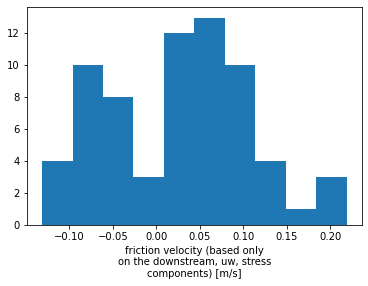

In [23]:
ds.ustar.plot.hist();

In [30]:
np.abs(np.nanmean(ds.bulk_z0))

0.00032705882937835617

In [25]:
np.abs(0.)/.41 * np.log(1/0.003)

7.792752791884672

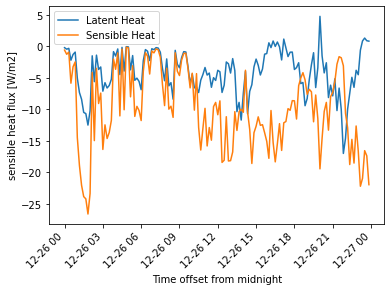

In [23]:
fig, ax = plt.subplots()
ds['bulk_Hl'].plot(x='time',ax=ax, label='Latent Heat')
ds['bulk_Hs'].plot(x='time', ax=ax, label='Sensible Heat')


# ds2.plot.scatter(x='time', y='Hl', ax=ax, label='Latent Heat')
ax.tick_params(axis='x', labelrotation=45)
ax.legend()

Figure to match Andreas 2002 to test his model of turbulent scaling. zs/z0 is related to the Reynold's roughness through:
$$ln(z_s/z_0) = b0 + b1 ln(R_*) + b2 ln(R_*)^2$$

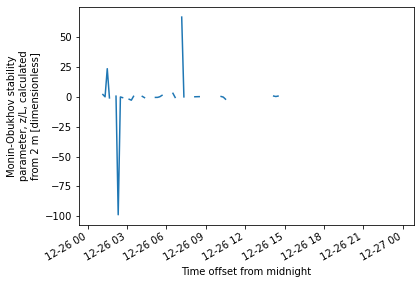

In [21]:
ds['zeta_level_n'].plot()

In [38]:
ds2_hourly = ds2.resample(time='H').mean()
ds2_hourly
hourly_perturbations = []
for hour in range(0,24,1):
    min_start = hour*60
    
    tmp = ds2_hourly.isel(time=hour) - ds2.isel(time=slice(min_start,min_start+60))
    tmp.drop_dims('time_local')
    hourly_perturbations.append(tmp)


In [71]:
ds2_perturbations = xr.concat(hourly_perturbations, dim='time')

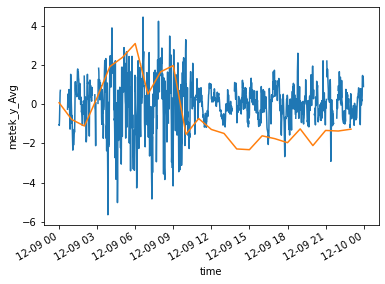

In [74]:
ds2_perturbations['metek_y_Avg'].plot()
ds2_hourly['metek_y_Avg'].plot()


In [77]:
ds2_perturbations = ds2_perturbations.drop_dims('time_local')